<a href="https://colab.research.google.com/github/mihailovvg/DS/blob/master/_6_2_6_Bunch%2BFT%2BTTA%2Bout_subm14_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Загрузка** **датасета**

In [ ]:
import os
import json
import gzip
import pandas as pd
import numpy as np
from urllib.request import urlopen
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install kaggle
import json
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c sf-dl-car-classification -p /content

Saving kaggle.json to kaggle.json
 98% 479M/489M [00:04<00:00, 131MB/s]
100% 489M/489M [00:04<00:00, 121MB/s]
 99% 1.10G/1.11G [00:12<00:00, 75.2MB/s]
100% 1.11G/1.11G [00:12<00:00, 92.2MB/s]
  0% 0.00/78.7k [00:00<?, ?B/s]
100% 78.7k/78.7k [00:00<00:00, 64.1MB/s]
  0% 0.00/196k [00:00<?, ?B/s]
100% 196k/196k [00:00<00:00, 64.9MB/s]


In [ ]:

!unzip /content/test.zip
!unzip /content/train.zip

In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")

sample_submission = pd.read_csv("/content/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
sample_submission.shape

(6675, 2)

2. **Загрузка фреймворка и формирование нормализованного датабанча {train, valid, test} с базовой аугментацией; размер 299х299** 

In [ ]:
from fastai.vision import *
from fastai.metrics import *
from fastai.core import *
from fastai.basics import *
#fastai2 instal
#!pip install fastai2 -q
#from fastai2.basics import *
#from fastai2.vision.all import *
#from fastai2.callback.all import *

In [ ]:
path = "train"
size = 299
bs = 16
tfms = get_transforms(do_flip=True)
#test = ImageList.from_folder("test_upload")
test = ImageList.from_df(sample_submission, path="/content/",folder="test_upload")
data = ImageDataBunch.from_folder(path, seed=42,
                                  ds_tfms=tfms,
                                  valid_pct=0.2, 
                                  size=size, 
                                  bs=bs)
                                 
data.add_test(test)                                  
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (12449 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
0,0,0,0,0
Path: train;

Valid: LabelList (3112 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
0,3,1,1,4
Path: train;

Test: LabelList (6675 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: train

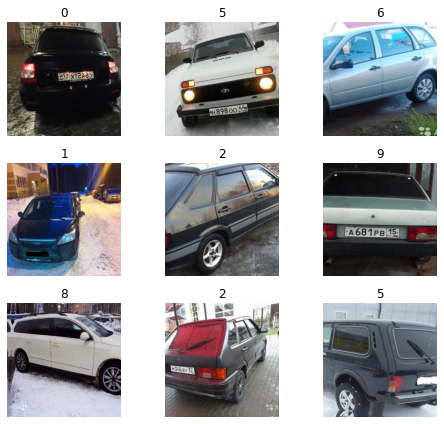

In [ ]:
data.show_batch(rows=3, figsize=(7,6))


In [ ]:
data.batch_stats(ds_type=DatasetType.Test) # убедились, что тест нормализован

[tensor([0.0228, 0.2027, 0.4825]), tensor([1.1826, 1.1807, 1.1570])]

In [ ]:
tfms #параметры аугментации

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.32667263813552183, 'col_pct': 0.9653714961864857, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=False, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([ 0.0789,  0.0041,  0.0986, -0.1691]), 'invert': False}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={'degrees': -7.251234665513094}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0652401710559807, 'row_pct': 0.6622255594538548, 'col_pct': 0.9652291999354111}, do

**3. Загрузка предобученной модели resnet101 и выбор LR**

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
None


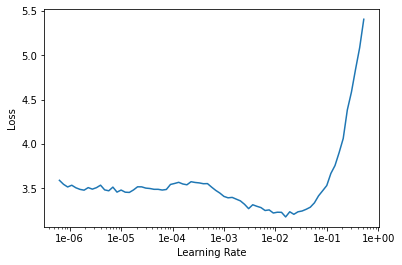

In [ ]:
learner = cnn_learner(data, models.resnet101, metrics=[accuracy], callback_fns=ShowGraph)
lr_min = learner.lr_find()
print(lr_min)
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.464247,0.308245,0.888175,06:29
1,0.348806,0.190242,0.925450,06:30
2,0.231388,0.153646,0.937339,06:29


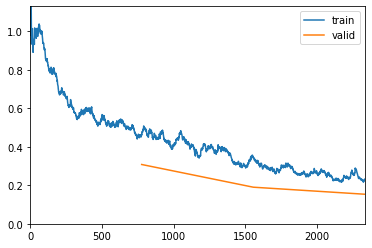

In [ ]:
lr = 1e-3 # чуть меньше минимума
learner.fit_one_cycle(3, lr)


**4. Fine tuning** **и выбор диапазона LR**

In [ ]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


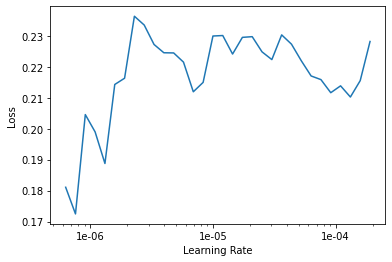

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.206936,0.154907,0.941838,08:01
1,0.174400,0.145561,0.942802,08:02
2,0.183589,0.132676,0.946979,08:04
3,0.123492,0.122863,0.953085,08:02
4,0.120391,0.118932,0.953727,08:03


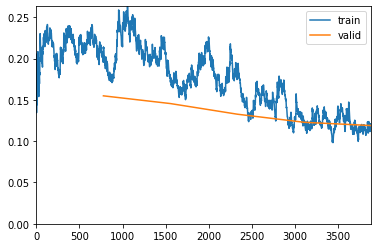

In [ ]:
learner.fit_one_cycle(5, max_lr=slice(1e-6,1e-4)) 

**5. TTA на валидации  и экспорт модели**

In [ ]:
preds,y = learner.TTA()

In [ ]:
accuracy(preds,y) # получено улучшение метрики с TTA

tensor(0.9512)

In [ ]:
preds.shape

In [ ]:
learner.export()

**6. Интерпретация модели**

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

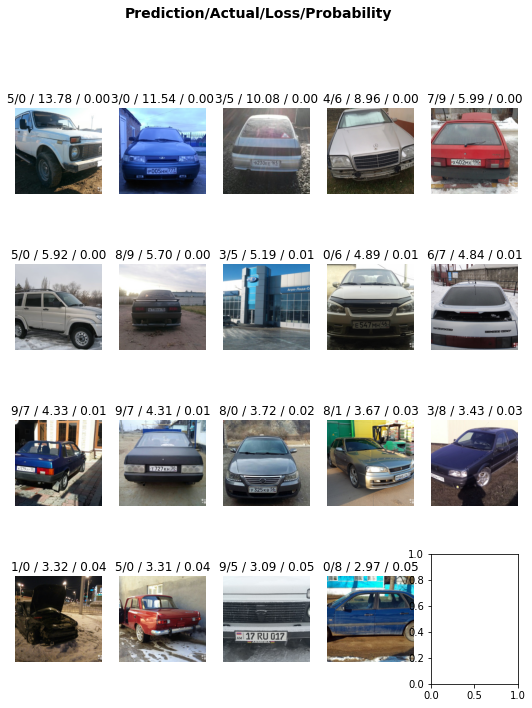

In [ ]:
interp.plot_top_losses(19, figsize=(9,11))

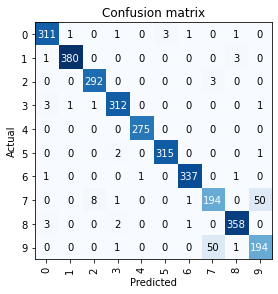

In [ ]:
interp.plot_confusion_matrix() #основная ошибка - путает классы: 7/9 и 9/7


**7. Предсказание на тесте с TTA и формирование submission**

In [ ]:
preds,y = learner.TTA(ds_type=DatasetType.Test)


In [ ]:
y = np.argmax(preds, 1)
submission = pd.DataFrame(data={'Id':sample_submission.Id, 'Category': y}) 
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 22           |        cudaMalloc retries: 25        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5532 MB |   10725 MB |   82638 GB |   82633 GB |\n|       from large pool |    5361 MB |   10572 MB |   82618 GB |   82612 GB |\n|       from small pool |     170 MB |     339 MB |      20 GB |      20 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5532 MB |   10725 MB |   82638 GB |   82633 GB |\n|       from large pool |    5361 MB |   10572 MB |